In [2]:
from fastai.vision.all import *

/usr/local/lib/python3.8/dist-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


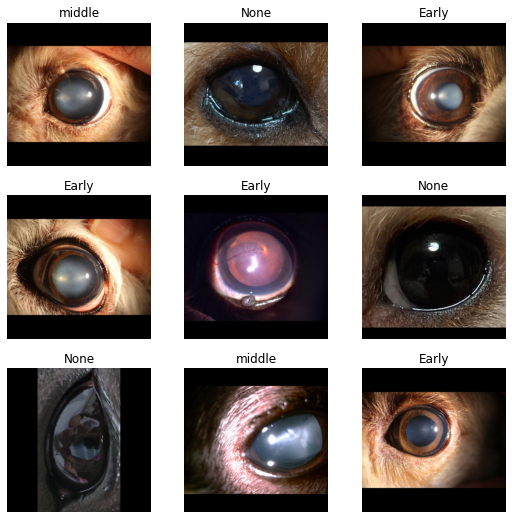

In [4]:
path = 'images/백내장/'

block = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    get_y = parent_label,
)

loader = block.dataloaders(path)

loader.show_batch()

In [21]:
learn = vision_learner(loader, resnet18, metrics=accuracy)

learn.fine_tune(epochs = 100)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,time
0,0.791093,0.651108,0.700636,00:59


epoch,train_loss,valid_loss,accuracy,time
0,0.562135,0.510732,0.782925,01:18
1,0.447160,0.458148,0.808901,01:18
2,0.320040,0.431586,0.823070,01:18


KeyboardInterrupt: 

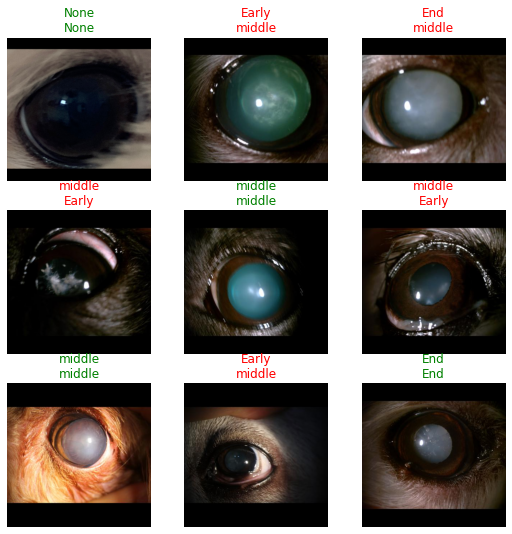

In [6]:
learn.show_results()

torch.Size([1, 3, 400, 400]) torch.Size([1, 3, 400, 400])


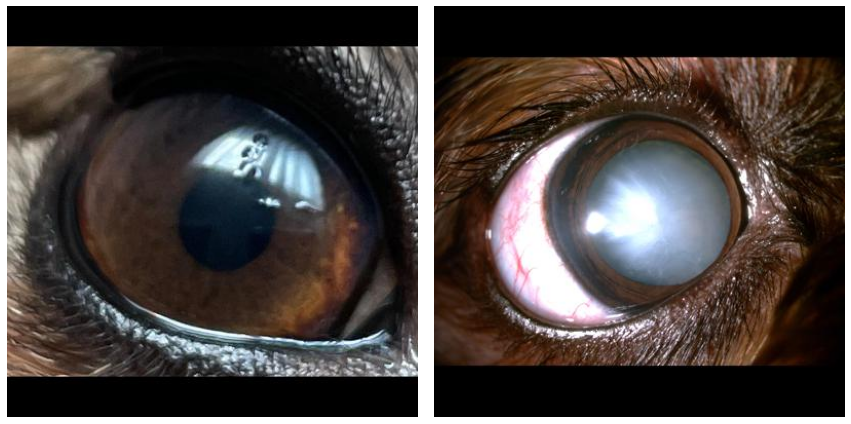

In [7]:
neg_path = 'images/백내장/None/crop_D0_2a5940ad-60a5-11ec-8402-0a7404972c70.jpg'
pos_path = 'images/백내장/End/crop_D0_0dc420f8-60a5-11ec-8402-0a7404972c70.jpg'

test_loader = loader.test_dl([neg_path, pos_path])

neg_x, pos_x = next(iter(test_loader))[0]

neg_x = neg_x.unsqueeze(0)
pos_x = pos_x.unsqueeze(0)

print(neg_x.shape, pos_x.shape)

neg_img = Image.open(neg_path)
pos_img = Image.open(pos_path)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(neg_img)
ax[0].axis('off')
ax[1].imshow(pos_img)
ax[1].axis('off')
plt.tight_layout()
plt.show()

In [8]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o):
        self.stored = o.detach().clone()
    def __enter__(self, *args):
        return self
    def __exit__(self, *args):
        self.hook.remove()

class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)  
    def hook_func(self, m, gi, go):
        self.stored = go[0].detach().clone()
    def __enter__(self, *args):
        return self
    def __exit__(self, *args):
        self.hook.remove()

torch.Size([25, 25])


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1315: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


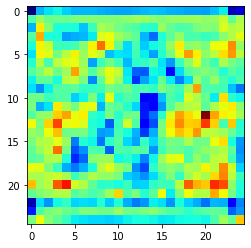

In [9]:
def get_gradcam(x, location=-1):
    with HookBwd(learn.model[0][location]) as hookg:
        with Hook(learn.model[0][location]) as hook:
            output = learn.model.eval()(x.cuda())
            idx = torch.argmax(output)
            act = hook.stored
        output[0, idx].backward()
        grad = hookg.stored

    w = grad[0].mean(dim=[1, 2], keepdim=True)
    heatmap = (w * act[0]).sum(0).detach().cpu()

    return heatmap

heatmap = get_gradcam(pos_x, location=-2)

print(heatmap.shape)
plt.imshow(heatmap, cmap='jet')
plt.show()

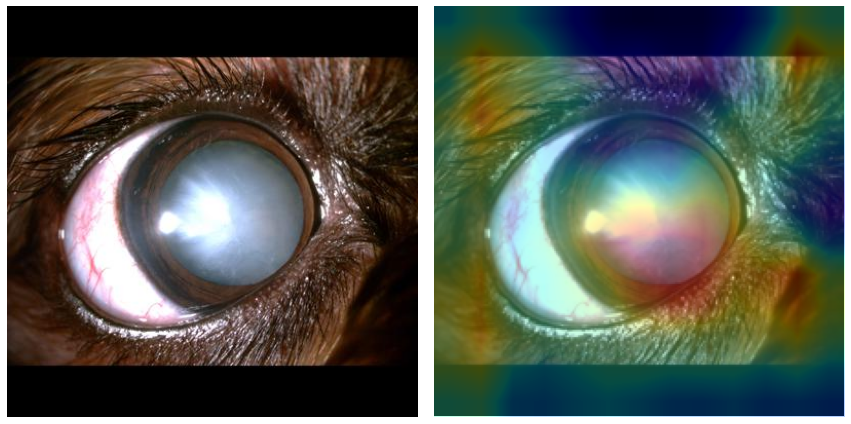

In [19]:
img = Image.open(pos_path)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img)
ax[0].axis('off')

heatmap_image = img.copy()
heatmap_image = heatmap_image.resize((224, 224))  # heatmap 이미지 크기 조정

ax[1].imshow(heatmap_image)
ax[1].imshow(heatmap.cpu(), alpha=0.3, extent=(0, 224, 224, 0),
              interpolation='bilinear', cmap='jet')
ax[1].axis('off')
plt.tight_layout()
plt.show()

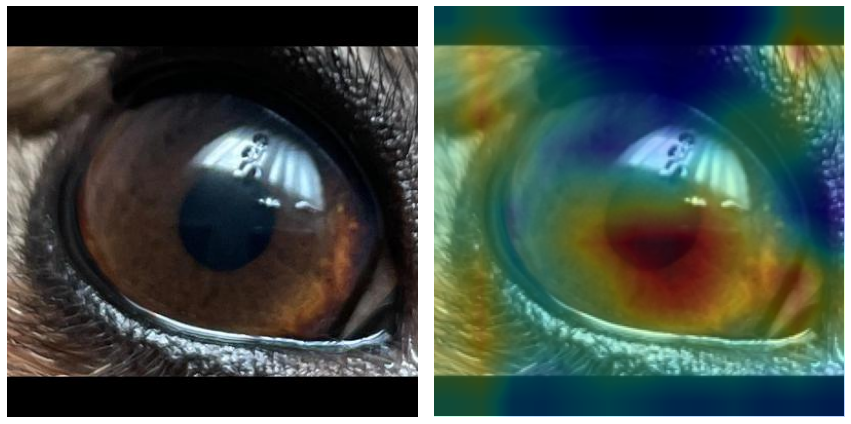

In [20]:
img = Image.open(neg_path)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img)
ax[0].axis('off')

heatmap_image = img.copy()
heatmap_image = heatmap_image.resize((224, 224))  # heatmap 이미지 크기 조정

ax[1].imshow(heatmap_image)
ax[1].imshow(heatmap.cpu(), alpha=0.3, extent=(0, 224, 224, 0),
              interpolation='bilinear', cmap='jet')
ax[1].axis('off')
plt.tight_layout()
plt.show()